<font size="4"> We need ase, nglview, phonopy, and hiphive to run this. All these python packages can be installed by pip.

In [2]:
import os
import numpy as np
import subprocess
import glob
import os
import shutil
import nglview

import pymatgen as pmg
from pymatgen.io.vasp.outputs import Vasprun
import phonopy
from phonopy import Phonopy
from phonopy.structure.atoms import Atoms as PhonopyAtoms
from ase.io import read, write
from ase.visualize import view
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections

%matplotlib inline
import matplotlib.pyplot as plt

<font size="4"> Lets view the structure

In [3]:
prim = read('POSCAR')
view(prim, viewer='ngl')

<font size="4"> Generate the displaced supercells to start the phonon calculations. Make a directory name poscars with all the displacements.

In [6]:
# Generate the displaced supercells
subprocess.call('phonopy -d --dim=\"5 5 1\"', shell=True)
#os.makedirs('poscars')
subprocess.call('mv POSCAR-* poscars', shell=True)

        _
  _ __ | |__   ___  _ __   ___   _ __  _   _
 | '_ \| '_ \ / _ \| '_ \ / _ \ | '_ \| | | |
 | |_) | | | | (_) | | | | (_) || |_) | |_| |
 | .__/|_| |_|\___/|_| |_|\___(_) .__/ \__, |
 |_|                            |_|    |___/
                                      2.12.0

Python version 3.8.10
Spglib version 1.16.3

Crystal structure was read from "POSCAR".
Unit of length: angstrom
Displacements creation mode
Settings:
  Supercell: [5 5 1]
Spacegroup: P-6m2 (187)
Use -v option to watch primitive cell, unit cell, and supercell structures.

"phonopy_disp.yaml" and supercells have been created.

Summary of calculation was written in "phonopy_disp.yaml".
                 _
   ___ _ __   __| |
  / _ \ '_ \ / _` |
 |  __/ | | | (_| |
  \___|_| |_|\__,_|



0

In [15]:
s_cell = read('SPOSCAR')
view(s_cell, viewer='ngl')

<font size="4"> We run the DFT calculations on the displaced supercell. Here we are using VASP. Next we collect the vas output from vasprun.xml files to generate interatomic force constants. "--writefc --hdf5 --full-fc" command converts the IFCs to hdf5 format.

In [7]:
subprocess.call('phonopy -f 001/vasprun.xml 002/vasprun.xml 003/vasprun.xml', shell=True)
subprocess.call('phonopy --writefc --hdf5 --full-fc  --dim="5 5 1"', shell=True)

        _
  _ __ | |__   ___  _ __   ___   _ __  _   _
 | '_ \| '_ \ / _ \| '_ \ / _ \ | '_ \| | | |
 | |_) | | | | (_) | | | | (_) || |_) | |_| |
 | .__/|_| |_|\___/|_| |_|\___(_) .__/ \__, |
 |_|                            |_|    |___/
                                      2.12.0

Python version 3.8.10
Spglib version 1.16.3

Displacements were read from "phonopy_disp.yaml".
counter (file index): 1 2 3 
"FORCE_SETS" has been created.
                 _
   ___ _ __   __| |
  / _ \ '_ \ / _` |
 |  __/ | | | (_| |
  \___|_| |_|\__,_|

        _
  _ __ | |__   ___  _ __   ___   _ __  _   _
 | '_ \| '_ \ / _ \| '_ \ / _ \ | '_ \| | | |
 | |_) | | | | (_) | | | | (_) || |_) | |_| |
 | .__/|_| |_|\___/|_| |_|\___(_) .__/ \__, |
 |_|                            |_|    |___/
                                      2.12.0

Python version 3.8.10
Spglib version 1.16.3

Crystal structure was read from "POSCAR".
Unit of length: angstrom
Settings:
  Supercell: [5 5 1]
Spacegroup: P-6m2 (187)
Use -v opt

0

<font size="4"> Lets plot the phonon dispersion along the high symmetric path.

Supercell structure was read from "SPOSCAR".
Force constants were read from "force_constants.hdf5".


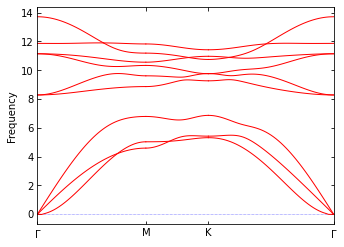

In [8]:
import phonopy
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
phonon = phonopy.load(supercell_filename="SPOSCAR", log_level=1)
path = [[[0, 0, 0], [1/2, 0, 0], [1/3, 1/3, 0.0], [0,0,0]]]
labels = ["$\\Gamma$", "M","K", "$\\Gamma$"]
qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=51)
phonon.run_band_structure(qpoints, path_connections=connections, labels=labels)
phonon.plot_band_structure().show()

<font size="4"> Lets enforce all the symmetry constraints on the calculated IFCs using hiphive.

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from ase.io import read, write
from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms

from hiphive import ForceConstants, ClusterSpace, ForceConstantPotential
from hiphive import enforce_rotational_sum_rules
from hiphive.utilities import extract_parameters


from hiphive import ForceConstants
from hiphive.utilities import extract_parameters
from hiphive import enforce_rotational_sum_rules
from trainstation import Optimizer

<font size="4"> Read the calculated phonopy IFCS to and parse them as hiphive force constants object. We will next to define a cutoff here. Maximum possible cutoff is L/2, L being the smallest lattice vector of a supercell. (a or b in the case of a monolayer) 

In [10]:
# read atoms and force constants
# Use calculated phonopy IFCS to and parse them as hiphive FCP
prim = read('POSCAR')
supercell = read('SPOSCAR')
fcs_phonopy = ForceConstants.read_phonopy(supercell, 'force_constants.hdf5')
cutoff = 7.8

In [11]:
cs = ClusterSpace(prim, [cutoff])
parameters = extract_parameters(fcs_phonopy, cs)
enforced_parameters = enforce_rotational_sum_rules(cs, parameters, ['Huang', 'Born-Huang'])
fcp_rot = ForceConstantPotential(cs, enforced_parameters)
fcs_hiphive_rot = fcp_rot.get_force_constants(supercell)

Primitive cell:
    Formula: MoS2
    Cell:
        [  3.18999   0.00000   0.00000]
        [ -1.59500   2.76261   0.00000]
        [  0.00000   0.00000  21.14717]
    Basis:
        Mo  [  0.00000   0.00000   0.50000]
        S   [  0.66667   0.33333   0.42622]
        S   [  0.66667   0.33333   0.57378]

Crystal symmetry:
    Spacegroup:          P-6m2 (187)
    Unique site:         2
    Symmetry operations: 12
    symprec:             1.00e-05

Cutoffs:
    Maximum cutoff: 7.8
    Found 3 center atoms with 66 images totaling 69 atoms

Clusters:
    Clusters: {2: 176}
    Total number of clusters: 176

Orbits:
    Orbits: {2: 17}
    Total number of orbits: 17

Eigentensors:
    Eigentensors: {2: 84}
    Total number of parameters: 84

Constraints:
    Acoustic: True
    Number of degrees of freedom: {2: 80}
    Total number of degrees of freedom: 80
Force constant reconstruction error order 2:    0.2369%
Rotational sum-rules before, ||Ax|| =    6.628932266186494
Rotational sum-rule

In [12]:
# This generates the q mesh needed for calculations of phonon dispersion.

THz_to_meV = 4.13567

def get_band(q_start, q_stop, N):
    """ Return path between q_start and q_stop """
    return np.array([q_start + (q_stop-q_start)*i/(N-1) for i in range(N)])

def plot_dispersion(fcs, color, label):
    # set force constants
    phonon.set_force_constants(fcs.get_fc_array(order=2))

    # get dispersion
    phonon.set_band_structure(bands)
    _, qnorms, freqs, _ = phonon.get_band_structure()
    qnorms = np.hstack(qnorms)
    freqs = THz_to_meV * np.vstack(freqs)
    lines = ax1.plot(qnorms, freqs, color=color)
    lines[0].set_label(label)

# define band path
N_band_pts = 500
G2M = get_band(np.array([0.0, 0.0, 0.0]), np.array([1/2, 0, 0.0]), N_band_pts)
M2K = get_band(np.array([1/2, 0.0, 0.0]), np.array([1/3, 1/3, 0.0]), N_band_pts)
K2G= get_band(np.array([1/3, 1/3, 0.0]), np.array([0, 0, 0.0]), N_band_pts)
bands = [G2M]

Max drift of force constants: -0.003466 (zz) 0.000005 (xx)
Max drift of force constants: 0.000000 (yy) 0.000000 (yy)


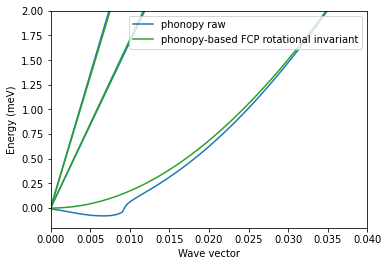

In [14]:
# plotting
fig = plt.figure(figsize=(5.5, 3.8))
ax1 = fig.add_subplot(111)

#ax1.axhline(y=0.0, ls='-', c='k', lw=1.0)
plot_dispersion(fcs_phonopy, 'tab:blue', 'phonopy raw')
plot_dispersion(fcs_hiphive_rot, 'tab:green', 'phonopy-based FCP rotational invariant')

# show
ax1.legend(loc=1)
ax1.set_xlim(0, 0.04)
ax1.set_ylim(-0.2, 2)

ax1.set_xlabel('Wave vector')
ax1.set_ylabel('Energy (meV)')

fig.tight_layout()
fig.savefig('MoS2_phonon_dispersion.svg')